In [2]:
import numpy as np
import operator
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


## Reading dataset

[Dataset link](https://www.kaggle.com/arhamrumi/amazon-reviews-eda-20012018)


In [3]:
sports = pd.read_csv("Sports_and_Outdoors.csv")
sports.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12969732 entries, 0 to 12969731
Data columns (total 6 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   rating      int64 
 1   verified    bool  
 2   reviewerID  object
 3   product_id  object
 4   date        int64 
 5   vote        object
dtypes: bool(1), int64(2), object(3)
memory usage: 507.1+ MB


### Dropping columns not used for analysis

In [4]:
sports.drop(['verified', 'vote'], axis=1, inplace=True)
sports = sports.sort_values('date', ascending=False)
sports.head()


,rating,reviewerID,product_id,date
12968859,3,AAL07KPFE0VFI,B01HIT0QDG,1538697600
12969474,5,A39ANO7WWQ9PE8,B01HJA3STS,1538697600
12969475,5,A4HCTG3TV7UPM,B01HJA3STS,1538611200
12969105,1,A30DF0WFD9U1PT,B01HIY7NPU,1538611200
12965742,5,A2WCAIO2XACZ01,B01HGSLB6K,1538611200


In [5]:
products = sports['product_id'].unique()
users = sports['reviewerID'].unique()
print('Number of unique products', len(products))
print('Number of unique users', len(users))


Number of unique products 957764
Number of unique users 6703391




* Making a dictionary to store all ratings given by users to a particular product  



In [6]:
all_products = defaultdict(dict)
for ind in sports.itertuples():
    all_products[ind.product_id][ind.reviewerID] = ind.rating
all_products = dict(all_products)


  

* Removing all products for which only 1 rating has been given   



In [7]:
new_all = defaultdict(dict)
product_id_nottake = set()
for i, val in all_products.items():
    if len(val) > 1:
        new_all[i] = val.copy()
    else:
        product_id_nottake.add(i)
new_all = dict(new_all)
all_products = new_all


   

* Making a dictionary to store all ratings given to products by a particular user  
(Note that the products which had only 1 rating will not be reflected in this dictionary)   



In [8]:
all_users = defaultdict(dict)
for ind in sports.itertuples():
    if ind.product_id not in product_id_nottake:
        all_users[ind.reviewerID][ind.product_id] = ind.rating
all_users = dict(all_users)


## Making the data centered around zero

> This is a preprocessing step which helps us in computing the **Pearson correlation**.   
 
$r =\frac{\sum\left(x_{i}-\bar{x}\right)\left(y_{i}-\bar{y}\right)}{\sqrt{\sum\left(x_{i}-\bar{x}\right)^{2} \sum\left(y_{i}-\bar{y}\right)^{2}}}$  

$r$	= Correlation coefficient  
$x_{i}$	=	values of the x-variable in a sample  
$\bar{x}$ =	mean of the values of the x-variable  
$y_{i}$	=	values of the y-variable in a sample  
$\bar{y}$	=	mean of the values of the y-variable  

We assume that a value of zero is given to all the products for which ratings haven't been given by a particular user.Thus, the set of all ratings for a given user can now be considered as a vector.  



In [9]:
epsilon = 1e-6
normalized_products = defaultdict(dict)
for i, val in all_products.items():
    normalized_products[i] = val.copy()
for i, val in normalized_products.items():
    values = list(val.values())
    mean_val = np.mean(values)
    for j in val:
        val[j] -= mean_val



* For the each of the vectors defined in the previous step, we find the magnitudes.

 

In [10]:
magnitudes = defaultdict(dict)

for i in normalized_products:
    values = list(normalized_products[i].values())
    magnitudes[i] = np.sqrt(np.sum(np.square(values)))


### TODO:

In [11]:
user = sports['reviewerID'].value_counts().idxmax()
sample_user = user
sample_user


'A3OXHLG6DIBRW8'



* Getting all the products which have more than 1 rating and which have not been rated by the selected user



In [12]:
rest = list(set(all_products.keys()) - set(all_users[sample_user]))




* Choosing random 1000 products out of the list generated in the previous step



In [13]:
random1000 = np.random.choice(rest, size=1000)




*  Getting the list of all products for which ratings have been given by the sample user.  



In [14]:
compare_with = list(all_users[sample_user])




For each of the products among the 1000 that we chose randomly, we try to predict the ratings which would have been given by the sample user. In order to acheive this, we find the similarity coefficient between the product whose rating is to be predicted, and all those products for which ratings have already been given by the sample user. Once we have the similarity coefficients, we predict the rating for that particular product using the formula :

$ \large R(u, j) = \large\frac{\large\sum\limits_{i \ \epsilon \ compare \_ with} S_{ij} \ . \ R(u, i)}{\large\sum S_{ij}} $  


In [15]:
prediction_dict = defaultdict(dict)

for item in random1000:
    sine, calc = dict(), []
    for rated in compare_with:
        if rated not in magnitudes:
            continue
        coeff = 0
        for user in normalized_products[item]:
            if user not in normalized_products[rated]:
                continue
            coeff += normalized_products[item][user] * \
                normalized_products[rated][user]
        if magnitudes[rated] == 0 and magnitudes[item] == 0:
            sine[rated] = 1
        elif magnitudes[rated] == 0 or magnitudes[item] == 0:
            sine[rated] = 0
        else:
            sine[rated] = coeff / (magnitudes[rated] * magnitudes[item])

    coeffs = list()

    sorted_sine = dict(
        sorted(sine.items(), key=operator.itemgetter(1), reverse=True))
    maxrange = min(len(sorted_sine.values()), 100)
    for i in sine:
        if sine[i] <= 0:
            continue
        calc.append(sine[i] * all_users[sample_user][i])
        coeffs.append(sine[i])
        maxrange -= 1
        if maxrange == 0:
            break
    if len(coeffs) == 0:
        continue
    prediction_dict[item] = sum(calc) / sum(coeffs)




Making a Data Frame having the products which the sample user has not rated yet, and the predicted rating value for the same.  



In [16]:
# now we will pick top 100 items to recommend to user
prediction_df = pd.DataFrame(prediction_dict.items(), columns=[
                             "product_id", "predicted_rating"])
prediction_df.head()


,product_id,predicted_rating
0,B00H2WOML2,4.857143
1,B019C3EUZ6,4.000000
2,B002AWO5VQ,4.857143
3,B008RDMPQO,4.857143
4,B001GAPY0E,4.857143


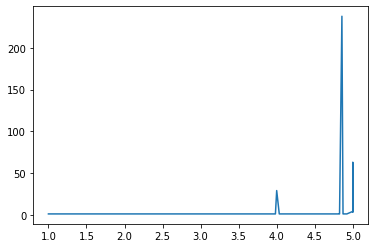

In [17]:
histogram = dict()
for i in prediction_df.itertuples():
    if i.predicted_rating not in histogram:
        histogram[i.predicted_rating] = 1
    else:
        histogram[i.predicted_rating] += 1
bar = sorted(histogram.items())
x, y = zip(*bar)
plt.plot(x, y)
plt.show()


In [18]:
results = prediction_df.sort_values(by="predicted_rating", ascending=False)
recommended_products = list()
for i in range(100):
    recommended_products.append(results.iloc[i]['product_id'])
print("Top 100 Recommended products for user " + str(sample_user) + " -")
for i in recommended_products:
    print(i)


Top 100 Recommended products for user A3OXHLG6DIBRW8 -
B005N7Y81C
B00LUH8QEY
B00MWENG58
B00AB87HH0
B009ZBZVCW
B01DIQD04A
B00XD2AEGM
B0066Q2MT4
B00KB28SYC
B001AS39LS
B01B4WOXZA
B007SGYXSO
B00ARAODCE
B005XWDA6G
B005FUKWG2
B01DHTXWKU
B00G2NC16A
B001C5KF84
B000ZK9G4G
B00CZ1CNV6
B00JXGT2A6
B015DBC0QC
B003UWLQEY
B007A4NF2Y
B00VQI5JYC
B00CZDTJSE
B000ROCF5W
B002BKEX32
B00FIVUR40
B00GM9TLSU
B001NZJPOI
B00CMJKP3Y
B00NYZGS7W
B00Q4AJABK
B00L4GH674
B00YUBTCNG
B001KN1LBI
B01DZMU21Q
B005IQS5WG
B01AU5QL1Q
B0015RZCZK
B00CIOGOYW
B00O53MF88
B005O1N7KK
B009AVNNDQ
B01HBARCA2
B007KKDGEK
B00IJNPHXU
B0062PLR9U
B005X71U1I
B004N9TCPS
B00BZTIRUU
B005CRAP06
B00194JDG8
B00OEJZKIK
B00YDQIUP4
B008NL4R2U
B013UAQC94
B01GOQGGJ2
B0009TTUT4
B01CJHDTV8
B018U47OCY
B0096NUDW2
B00M73Z6UM
B0042J7P12
B00AU6H68S
B00KNCUMO4
B00IUKR2IK
B000AYFRV8
B003SASU42
B00HZGN9BE
B00F0NSJKU
B001TED1Y8
B007DOTFMA
B002Z9NXJ4
B00G2TF292
B009CXGPJQ
B0052VIM6G
B005ZXSFEK
B00K7A9ZOK
B01GLPO3ZA
B00BVDR5FS
B0062OTIX8
B004S831SS
B005ESORF2
B00KU8ASM2